<a href="https://colab.research.google.com/github/dreyan22/PyTorch-Deep-Learning/blob/Computer-Vision/Cats_vs_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSCI 118.03 Image Classification Lab

This dataset is based off of Google's Dogs vs Cats image dataset.

## Objectives

* Be able to train a convolutional neural network for image classification
* Be able to customize the architecture of a CNN based neural network for image classification

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-03-03 11:27:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  29.5MB/s    in 2.2s    

2025-03-03 11:27:31 (29.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.580.jpg', 'cat.608.jpg', 'cat.435.jpg', 'cat.41.jpg', 'cat.203.jpg', 'cat.123.jpg', 'cat.459.jpg', 'cat.216.jpg', 'cat.930.jpg', 'cat.864.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

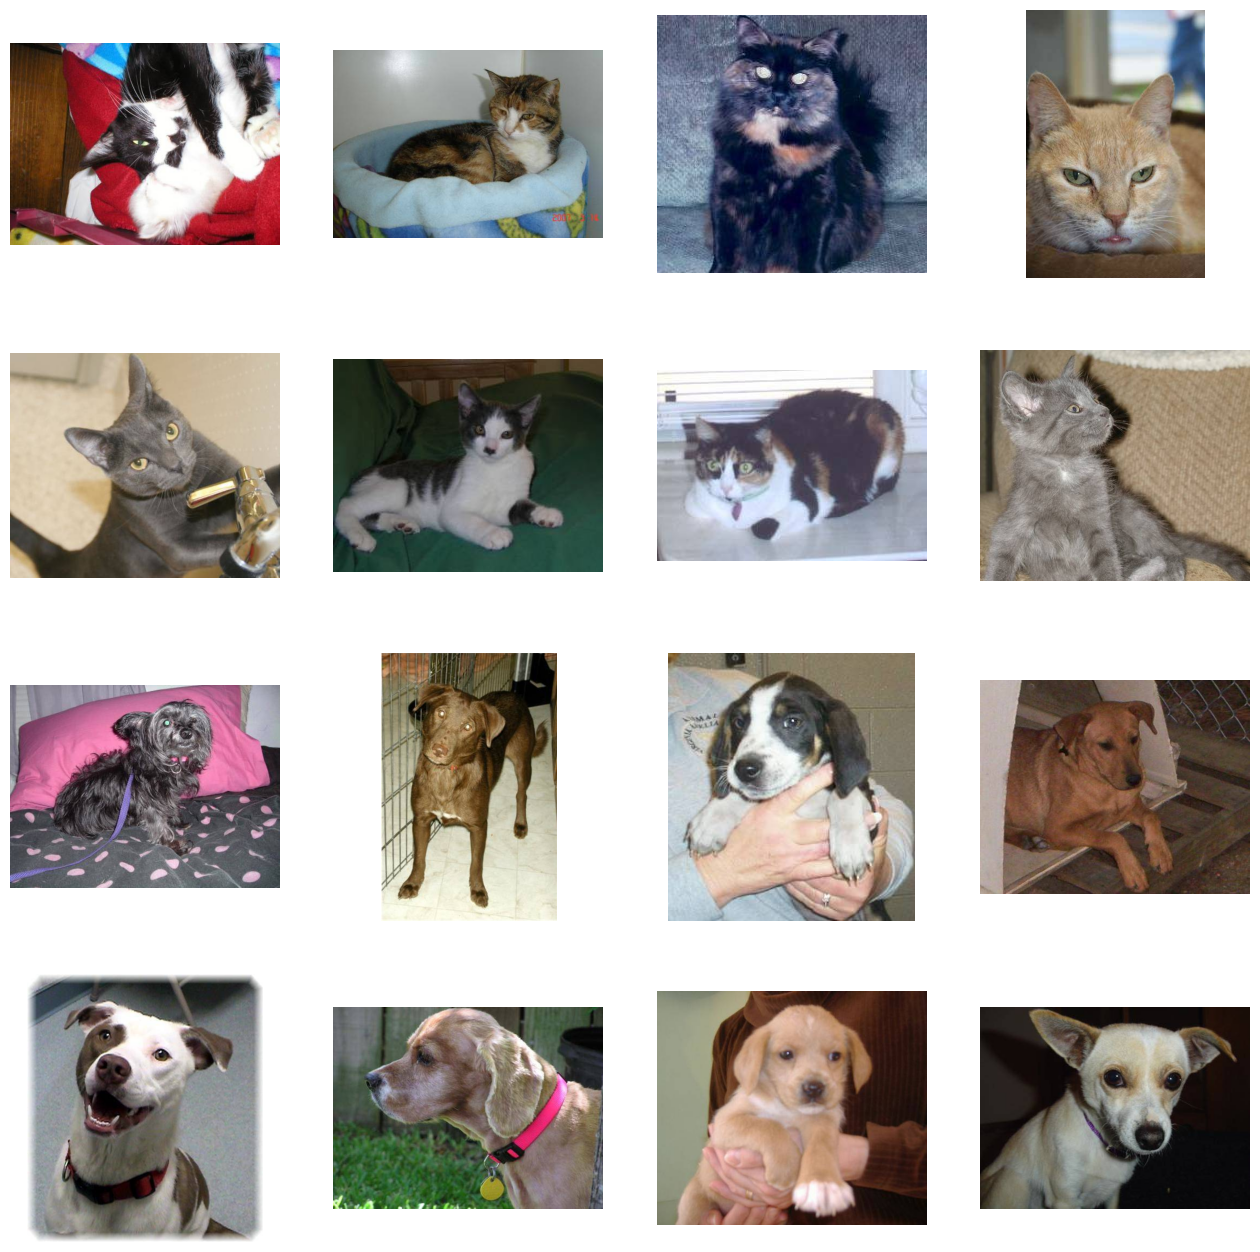

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Build a simple CNN based Neural Network

This is a starter code for a simple CNN based neural network for classifying dogs and cats and evaluating its performance.

In [ ]:
# Install required libraries
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.image as mpimg

# seed value
seed = 12

# Set fixed seed
torch.manual_seed(seed)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transforms for data preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

validation_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### CNN Models

In [ ]:
class NewSimpleCNN(nn.Module):
    def __init__(self):
        super(NewSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Create a dummy input to find out the size after conv layers
        self._initialize_fc()

    def _initialize_fc(self):
        # Forward pass a dummy input to calculate the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)  # Batch size 1, 3 channels, 150x150
            dummy_output = self.pool(torch.relu(self.conv2(self.pool(torch.relu(self.conv1(dummy_input))))))
            flattened_size = dummy_output.view(-1).shape[0]

        # Define fully connected layers based on this calculated size
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def name(self):
        return "NewSimpleCNN"

In [ ]:
# Accuracy: 71.60%
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Create a dummy input to find out the size after conv layers
        self._initialize_fc()

    def _initialize_fc(self):
        # Forward pass a dummy input to calculate the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)  # Batch size 1, 3 channels, 150x150
            dummy_output = self.pool(torch.relu(self.conv2(self.pool(torch.relu(self.conv1(dummy_input))))))
            flattened_size = dummy_output.view(-1).shape[0]

        # Define fully connected layers based on this calculated size
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

    def name(self):
        return "SimpleCNN"

In [ ]:
# Validation Accuracy: 78.10%
class CNNv1(nn.Module):
    def __init__(self):
        super(CNNv1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers
        self._initialize_fc()

    def _initialize_fc(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            dummy_output = self.pool(torch.relu(self.bn2(self.conv2(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn3(self.conv3(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn4(self.conv4(dummy_output))))
            flattened_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def name(self):
        return "CNNv1"

In [ ]:
# https://www.kaggle.com/code/sachinpatil1280/cats-vs-dogs-image-classification-using-cnn-95

class KaggleModel(nn.Module):
  def __init__(self):
    super(KaggleModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(256)

    self.bn5 = nn.BatchNorm1d(512)
    # self.bn5 = nn.LayerNorm(512)  # Replaces BatchNorm1d(512) for testing only
    self.softmax = nn.Softmax(dim=1)

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.2)

    self._initialize_fc()

  def _initialize_fc(self):
    with torch.no_grad():
      x = torch.zeros(1, 3, 150, 150)
      x = self.dropout(self.pool(self.bn1(self.relu(self.conv1(x)))))
      x = self.dropout(self.pool(self.bn2(self.relu(self.conv2(x)))))
      x = self.dropout(self.pool(self.bn3(self.relu(self.conv3(x)))))
      x = self.dropout(self.pool(self.bn4(self.relu(self.conv4(x)))))
      flattened_size = x.view(-1).shape[0]

    self.fc1 = nn.Linear(flattened_size, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
      x = self.dropout(self.pool(self.bn1(self.relu(self.conv1(x)))))
      x = self.dropout(self.pool(self.bn2(self.relu(self.conv2(x)))))
      x = self.dropout(self.pool(self.bn3(self.relu(self.conv3(x)))))
      x = self.dropout(self.pool(self.bn4(self.relu(self.conv4(x)))))

      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.bn5(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

  def name(self):
        return "KaggleModel"

# x = torch.randn((1, 3, 150, 150))  # Added batch dimension

# # Initialize model
# model = KaggleModel()

# # Forward pass
# preds = model(x)

# # Print output shapes
# print(f"Input shape: {x.shape}")    # Expected: (1, 3, 150, 150)
# print(f"Output shape: {preds.shape}")  # Expected: (1, 2)

# # Ensure output shape is correct
# assert preds.shape == (1, 2), f"Expected (1, 2), but got {preds.shape}"
# print("Test passed ✅")

In [ ]:
# https://github.com/vashiegaran/Pytorch-CNN-with-cats-and-dogs-/blob/main/CatvsDog.ipynb

class OnlineCNN(nn.Module):
    def __init__(self):
        super(OnlineCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )

        self._initialize_fc()

    def _initialize_fc(self):
        with torch.no_grad():
          out = torch.zeros(1, 3, 150, 150)
          out =self.layer1(out)
          out =self.layer2(out)
          out =self.layer3(out)
          flattened_size = out.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self,x):
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        out =out.view(out.size(0),-1)
        out =self.relu(self.fc1(out))
        out =self.fc2(out)
        return out

    def name(self):
        return "OnlineCNN"

### Setting hyperparameters

In [ ]:
# Set model
model = SimpleCNN().to(device)

# Define hyperparameters
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32

# Training the model
epochs = 10

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, worker_init_fn=np.random.seed(seed))
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False, worker_init_fn=np.random.seed(seed))

In [ ]:
# Get a batch from train_loader and get shape
image, _ = next(iter(train_loader))
print(f"Image shape: {image.shape}")

Image shape: torch.Size([32, 3, 150, 150])


### Training and Evaluating the model

Model: SimpleCNN


Epoch 1, Loss: 0.6726


Epoch 2, Loss: 0.6028


Epoch 3, Loss: 0.5662


Epoch 4, Loss: 0.5175


Epoch 5, Loss: 0.5029


Epoch 6, Loss: 0.4614


Epoch 7, Loss: 0.4445


Epoch 8, Loss: 0.3978


Epoch 9, Loss: 0.3759


Epoch 10, Loss: 0.3505


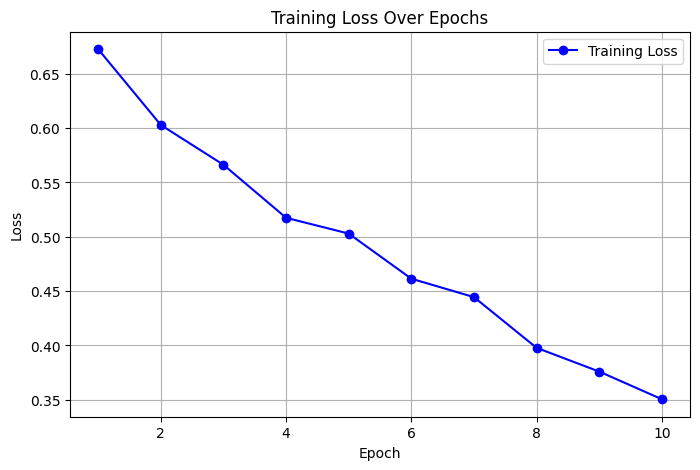

In [ ]:
loss_values = []

print(f"Model: {model.name()}")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_values.append(running_loss/len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


# Plot the loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(validation_loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nValidation Accuracy: {100 * correct / total:.2f}%')